In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gc
import os

In [2]:
with open('speeches-lemmatized-agg-ngrams-long.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df

speech  \
date       heading                                           mnis_id                                                      
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] 117      I congratulate the hon Member for Derby North ...   
                                                             1388     I join the Prime Minister and the Leader of th...   
                                                             14       I should like to express my gratitude to the v...   
                                                             1446     On a point of order, Mr Speaker. You said earl...   
                                                             1453     I want to pick the right hon Gentleman up on a...   
...                                                                                                                 ...   
2019-11-05 Valedictory Debate                                432      It seems only the blink of an eye since my hon...   
                                                             4455     On a point of order, Madam Deputy Speaker. As ...   
                                                             4524     I might have guessed, Madam Deputy Speaker. I ...   
                                                             553      I wanted to allow others to go first, but than...   
                                                             88       I was first elected to this place as the first...   

                                                                                                          lemmas_ngrams  
date       heading                                           mnis_id                                                     
2010-05-25 DEPUTY SPEAKERS Debate on the Address — [1st Day] 117      [congratulate, derby, north, chris, williamson...  
                                                             1388     [join, prime_minister, leader, opposition, pay...  
                                                             14       [like, express, gratitude, voter, wokingham, r...  
                                                             1446     [point_order_mr_speaker, early, sake, accuracy...  
                                                             1453     [pick, gentleman, different, talk, health, spe...  
...                                                                                                                 ...  
2019-11-05 Valedictory Debate                                432      [blink, eye, friends, eale, north, stephen, po...  
                                                             4455     [order, madam_deputy_speaker, order, seek, gui...  
                                                             4524     [guess, madam_deputy_speaker, course, abide, s...  
                                                             553      [allow, thank, madam_deputy_speaker, elect, mi...  
                                                             88       [elect, place, conservative, sit, constituency...  

[94713 rows x 2 columns]

In [3]:
# # https://stackoverflow.com/questions/62167850/python3-multiprocessing-pool-unbalanced-cpu-usage-on-compute-engine
# # "NumPy computations are not bound to any process, and need to to configured before running Python program"
# # "each NumPy related computation is restricted to its own assigned process"
# import os
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['NUMEXPR_NUM_THREADS'] = '1'
# os.environ['OMP_NUM_THREADS'] = '1'

## Prepare gensim dictionary and corpus

In [4]:
from gensim.corpora.dictionary import Dictionary

texts = df.lemmas_ngrams.values

d = Dictionary(texts)
corpus = [d.doc2bow(doc) for doc in texts]

## MALLET LDA

In [5]:
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from gensim.models.coherencemodel import CoherenceModel
import csv

In [6]:
def train_mallet(corpus, id2word_dict, n_topics_vals, 
                 optimize_interval=10, iterations=250, 
                 folder_path='topic-models', workers=7, mallet_path='~/mallet/mallet-2.0.8/bin/mallet', random_seed=1):
    
    for n in n_topics_vals:
        print(f'starting training {n}')
        
        # train mallet lda model of with n topics
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=n, id2word=id2word_dict,
                          random_seed=random_seed, 
                          iterations=iterations, 
                          optimize_interval=optimize_interval,
                          alpha=25, #lower than default 50. Intuition: few speeches in parliament discuss more than one topic
                          workers=workers) 
        print(f'{n} lda done')

        # save mallet lda model
        with open(f'{folder_path}/lda_mallet_{n}.pkl', 'wb') as f:
            pickle.dump(model, f)
        print(f'saved {n} lda')    

        # load document-topic matrix from file
        doc_topics_df = pd.read_csv(f'{model.fdoctopics()}', sep='\t', lineterminator='\n', header=None)
        doc_topics = doc_topics_df.values[:,2:]
        
        # if it doesn't exist, create doc-topics folder
        if not os.path.exists(f'{folder_path}/doc-topics'):
            os.makedirs(f'{folder_path}/doc-topics')
        
        # save doc_topics matrix to doc-topics folder
        with open(f'{folder_path}/doc-topics/lda_mallet_{n}_doc_topics.pkl', 'wb') as f:
            pickle.dump(doc_topics, f)
        print(f'saved {n} doc-topics')
        
        # clear from memory 
        del model
        del doc_topics
        del doc_topics_df
        gc.collect()
        print(f'done {n}\n')

        
def get_mallet_coherence(metrics, n_topics_vals, folder_path='topic-models', new_coherence_log=False, workers=-1, coherence_log_fname='coherences'):
    # if it doesn't exist, create coherence folder
    if not os.path.exists(f'{folder_path}/coherence'):
        os.makedirs(f'{folder_path}/coherence')
            
    # if it doesn't exist, create gensim folder
    if not os.path.exists(f'{folder_path}/gensim'):
        os.makedirs(f'{folder_path}/gensim')
    
    # if coherences log doesn't exist
    if not os.path.isfile(f'{folder_path}/coherence/{coherence_log_fname}.csv'):
        # initialize coherences log file
        with open(f'{folder_path}/coherence/{coherence_log_fname}.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['n_topics'] + metrics)
    
    # for each n_topics value
    for n in n_topics_vals:
        print(f'starting coherence {n}')
        
        # load relevant lda mallet model
        with open(f'{folder_path}/lda_mallet_{n}.pkl', 'rb') as f:
            model = pickle.load(f)
        print('loaded mallet model')
        
        # convert lda mallet model to gensim lda model and save to gensim folder
        gensim_lda_model = malletmodel2ldamodel(model)
        with open(f'{folder_path}/gensim/lda_gensim_{n}.pkl', 'wb') as f:
            pickle.dump(gensim_lda_model, f)
        print('converted to gensim')
        
        coherence = []
        for metric in metrics:
            if metric == 'u_mass':
                coherence_model = CoherenceModel(model=gensim_lda_model, corpus=corpus, coherence=metric, processes=workers)
            else:
                coherence_model = CoherenceModel(model=gensim_lda_model, texts=texts, coherence=metric, processes=workers)
            
            with open(f'{folder_path}/coherence/coherence_model_{metric}_{n}.pkl', 'wb') as f:
                pickle.dump(coherence_model, f)
            
            coherence.append(coherence_model.get_coherence())
        
        res = [str(n)] + [str(x) for x in coherence]
        with open(f'{folder_path}/coherence/{coherence_log_fname}.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow(res)
            
        print('calculated coherence')
        
        del model
        del gensim_lda_model
        gc.collect()
        
        print(f'done {n}\n')

# Experiments

In [8]:
if not os.path.exists(f'topic-models'):
    os.makedirs(f'topic-models')

## Coarse

### Train and save models

In [8]:
n_topics_vals = np.concatenate([
    np.arange(10,100,10),
    np.arange(100,201,20)
])

n_topics_vals

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 120, 140, 160,
       180, 200])

In [10]:
exp_path = 'coarse'
if not os.path.exists(f'topic-models/{exp_path}'):
    os.makedirs(f'topic-models/{exp_path}')

In [11]:
train_mallet(corpus=corpus, id2word_dict=d, 
             n_topics_vals=n_topics_vals, 
             folder_path=f'topic-models',
             iterations=1000,
             workers=15)
print('done training')

starting training 10
10 lda done
saved 10 lda
saved 10 doc-topics
done 10

starting training 20
20 lda done
saved 20 lda
saved 20 doc-topics
done 20

starting training 30
30 lda done
saved 30 lda
saved 30 doc-topics
done 30

starting training 40
40 lda done
saved 40 lda
saved 40 doc-topics
done 40

starting training 50
50 lda done
saved 50 lda
saved 50 doc-topics
done 50

starting training 60
60 lda done
saved 60 lda
saved 60 doc-topics
done 60

starting training 70
70 lda done
saved 70 lda
saved 70 doc-topics
done 70

starting training 80
80 lda done
saved 80 lda
saved 80 doc-topics
done 80

starting training 90
90 lda done
saved 90 lda
saved 90 doc-topics
done 90

starting training 100
100 lda done
saved 100 lda
saved 100 doc-topics
done 100

starting training 120
120 lda done
saved 120 lda
saved 120 doc-topics
done 120

starting training 140
140 lda done
saved 140 lda
saved 140 doc-topics
done 140

starting training 160
160 lda done
saved 160 lda
saved 160 doc-topics
done 160

start

In [12]:
get_mallet_coherence(metrics=['c_v'], n_topics_vals=n_topics_vals, 
                     folder_path=f'topic-models', new_coherence_log=True, coherence_log_fname='coherences', 
                     workers=15)
print('done coherence')

starting coherence 10
loaded mallet model
converted to gensim
calculated coherence
done 10

starting coherence 20
loaded mallet model
converted to gensim
calculated coherence
done 20

starting coherence 30
loaded mallet model
converted to gensim
calculated coherence
done 30

starting coherence 40
loaded mallet model
converted to gensim
calculated coherence
done 40

starting coherence 50
loaded mallet model
converted to gensim
calculated coherence
done 50

starting coherence 60
loaded mallet model
converted to gensim
calculated coherence
done 60

starting coherence 70
loaded mallet model
converted to gensim
calculated coherence
done 70

starting coherence 80
loaded mallet model
converted to gensim
calculated coherence
done 80

starting coherence 90
loaded mallet model
converted to gensim
calculated coherence
done 90

starting coherence 100
loaded mallet model
converted to gensim
calculated coherence
done 100

starting coherence 120
loaded mallet model
converted to gensim
calculated cohe

### plot results

In [20]:
c_df = pd.read_csv('topic-models/coarse/coherence/coherences.csv', index_col=0, header=0)#.rename(columns={1:'c_v'})

In [21]:
c_df

,c_v
n_topics,
10,0.461617
20,0.513109
30,0.535121
40,0.537646
50,0.545534
60,0.555033
70,0.545871
80,0.556128
90,0.546122


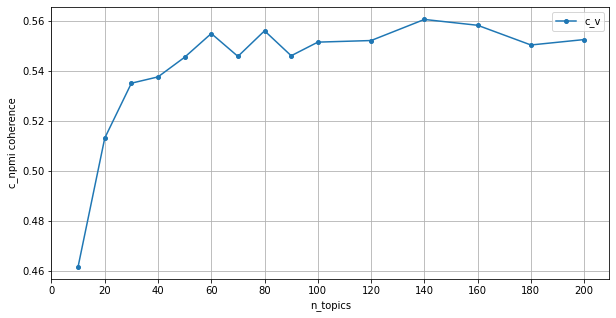

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
c_df.plot(y='c_v', ax=ax, marker='o', markersize=4)
plt.xticks(np.arange(0,201,20))
# ax.axhspan(0.078, 0.081, color='r', alpha=0.25)
# plt.ylim(())
# ax.axvspan(140, 330, alpha=0.25, color='r')
# ax.axvspan(140, 170, alpha=0.25, color='r')
# c_df[c_df.c_npmi > .0785].reset_index().plot.scatter(x='n_topics', y='c_npmi', ax=ax)
plt.xlabel('n_topics')
plt.ylabel('c_npmi coherence')
plt.grid()

# Fine

In [8]:
n_topics_vals = np.concatenate([
    np.arange(130,140),
    np.arange(141,160)
])
n_topics_vals

array([155, 156, 157, 158, 159])

In [10]:
exp_path = 'fine'
if not os.path.exists(f'topic-models/{exp_path}'):
    os.makedirs(f'topic-models/{exp_path}')

In [9]:
train_mallet(corpus=corpus, id2word_dict=d, 
             n_topics_vals=n_topics_vals, 
             folder_path=f'topic-models/fine',
             iterations=1000,
             workers=15)
print('done training')

starting training 155
155 lda done
saved 155 lda
saved 155 doc-topics
done 155

starting training 156
156 lda done
saved 156 lda
saved 156 doc-topics
done 156

starting training 157
157 lda done
saved 157 lda
saved 157 doc-topics
done 157

starting training 158
158 lda done
saved 158 lda
saved 158 doc-topics
done 158

starting training 159
159 lda done
saved 159 lda
saved 159 doc-topics
done 159

done training


In [11]:
get_mallet_coherence(metrics=['c_v'], n_topics_vals=n_topics_vals, 
                     folder_path=f'topic-models/fine', new_coherence_log=True, coherence_log_fname='coherences', 
                     workers=15)
print('done coherence')

starting coherence 130
loaded mallet model
converted to gensim
calculated coherence
done 130

starting coherence 131
loaded mallet model
converted to gensim
calculated coherence
done 131

starting coherence 132
loaded mallet model
converted to gensim
calculated coherence
done 132

starting coherence 133
loaded mallet model
converted to gensim
calculated coherence
done 133

starting coherence 134
loaded mallet model
converted to gensim
calculated coherence
done 134

starting coherence 135
loaded mallet model
converted to gensim
calculated coherence
done 135

starting coherence 136
loaded mallet model
converted to gensim
calculated coherence
done 136

starting coherence 137
loaded mallet model
converted to gensim
calculated coherence
done 137

starting coherence 138
loaded mallet model
converted to gensim
calculated coherence
done 138

starting coherence 139
loaded mallet model
converted to gensim
calculated coherence
done 139

starting coherence 141
loaded mallet model
converted to gens

In [4]:
coarse_df = pd.read_csv('topic-models/coarse/coherence/coherences.csv', index_col=0, header=0)
fine_df = pd.read_csv('topic-models/fine/coherence/coherences.csv', index_col=0, header=0)

In [13]:
fine_df

,c_v
n_topics,
130,0.561473
131,0.555916
132,0.561580
133,0.557831
134,0.565085
135,0.556361
136,0.555029
137,0.557267
138,0.559792


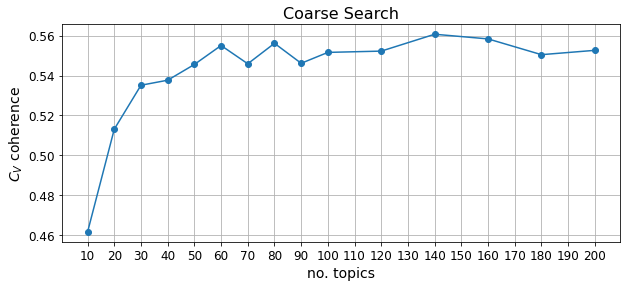

In [58]:
plt.figure(figsize=(10,4))
plt.plot(coarse_df.index, coarse_df.c_v.values, marker='o', markersize=6, linewidth=1.5)
# plt.legend()

plt.xlabel('no. topics', fontsize=14)
plt.ylabel('$C_V$ coherence', fontsize=14)

plt.xticks(np.arange(10,201,10), fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

plt.title('Coarse Search', fontsize=16)

plt.savefig('figures/LDA_coarse_search.png', dpi=150)

plt.show()

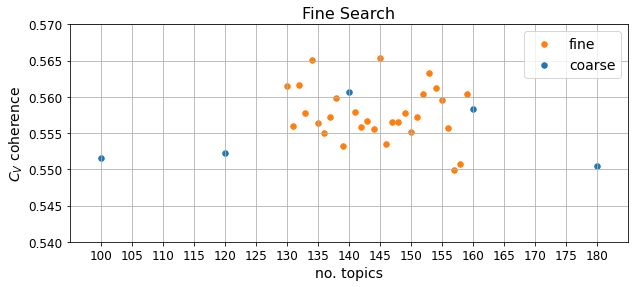

In [59]:
plt.figure(figsize=(10,4))
plt.scatter(fine_df.index, fine_df.c_v.values, s=30, c='tab:orange', label='fine')
# plt.plot(coarse_df.index, coarse_df.c_v.values, marker='o', markersize=5, linewidth=0.5, c='tab:blue', label='coarse')
# plt.scatter(coarse_df.index, coarse_df.c_v.values, s=40, facecolors='none', edgecolors='tab:blue', label='coarse')
plt.scatter(coarse_df.index, coarse_df.c_v.values, s=30, c='tab:blue', label='coarse')

plt.xlim((95,185))
plt.ylim((0.54,0.57))

plt.xlabel('no. topics', fontsize=14)
plt.ylabel('$C_V$ coherence', fontsize=14)

plt.xticks(np.arange(100,181,5), fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

plt.legend(fontsize=14)

max_coherence = np.around(np.max(fine_df.c_v.values), 5)
# plt.annotate(f'max\n{max_coherence}', (145.8, max_coherence+0.0005), fontsize=12)

plt.title('Fine Search', fontsize=16)

plt.savefig('figures/LDA_fine_search.png', dpi=150)

plt.show()